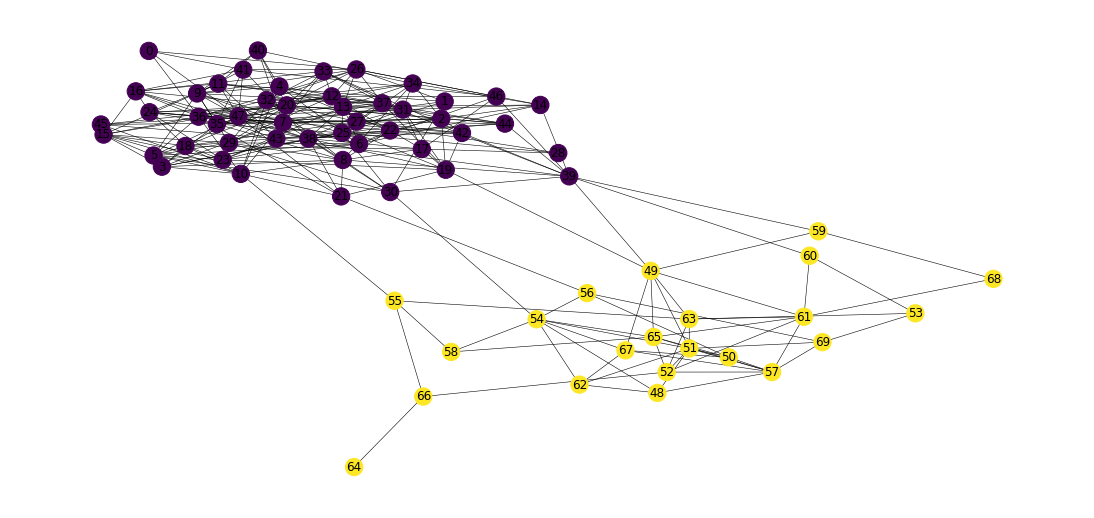

torch.Size([70, 70])


In [361]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import warnings 
warnings.filterwarnings("ignore")
# Let's create a stochastic block model
sizes = [48, 22]

probs = [[0.2, 0.007],
         [0.007, 0.2]]
         

G = nx.stochastic_block_model(sizes, probs, seed=0)
#Let's color the nodes with the same color of the block
for i in range(len(sizes)):
    for j in range(sizes[i]):
        G.nodes[j+i*48]['color'] = i
pos = nx.spring_layout(G,seed=42)
plt.figure(figsize=(15,7))
#draw nodes with mapped color
nx.draw(G,
        pos=pos,
        node_color=[G.nodes[node]['color'] for node in G.nodes()],
        edge_color='black',
        width=0.55,
        style='solid',
        linewidths=1,
        cmap=plt.cm.viridis,
        #node_size=100,
        with_labels=True,
        alpha=1,
        )

plt.show()
# Get the adjacency matrix
adj = nx.adjacency_matrix(G)
adj = torch.tensor(adj.todense()).float()
print(adj.shape)

In [362]:
#Let's save the degree of each node in a torch tensor
from torch_geometric.utils import to_dense_adj
print(len(G.nodes()))
degrees = torch.tensor([G.degree(node) for node in G.nodes()],dtype=torch.float32).reshape(-1,1)
#Parse the graph to a torch_geometric.data.Data object
from torch_geometric.utils import from_networkx
print(G)
A = G
C = nx.Graph()
C.add_nodes_from(A.nodes())
C.add_edges_from(A.edges())
data = from_networkx(C)
print(data)
data.x = to_dense_adj(data.edge_index)[0] #Adj 
data.y = torch.tensor([0,0,0,1,1,2,2,2,2]).reshape(-1,1)
data.edge_index = adj.nonzero().t()
L_normalized = torch.Tensor(nx.normalized_laplacian_matrix(C).todense())
print(L_normalized.shape)
print(data)

70
Graph named 'stochastic_block_model' with 70 nodes and 285 edges
Data(edge_index=[2, 570], num_nodes=70)
torch.Size([70, 70])
Data(edge_index=[2, 570], num_nodes=70, x=[70, 70], y=[9, 1])


In [363]:
from sklearn.model_selection import train_test_split
def rand_train_test_idx(label, train_prop=.5, valid_prop=.25, ignore_negative=True,seed=1234):
      
      """ randomly splits label into train/valid/test splits """
      train_idx, test_idx = train_test_split(np.arange(len(label)), train_size=train_prop, random_state=seed)
      val_idx, test_idx = train_test_split(test_idx, train_size=train_prop, random_state=seed)
      train_mask = torch.zeros(len(label), dtype=torch.bool)
      train_mask[train_idx] = True
      val_mask = torch.zeros(len(label), dtype=torch.bool)
      val_mask[val_idx] = True
      test_mask = torch.zeros(len(label), dtype=torch.bool)
      test_mask[test_idx] = True
      return train_mask, val_mask, test_mask

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of classes:  6
Number of nodes of class 0:  42
Number of nodes of class 1:  19
Number of nodes of class 2:  9
Data(edge_index=[2, 570], num_nodes=70, x=[70, 3703], y=[70])


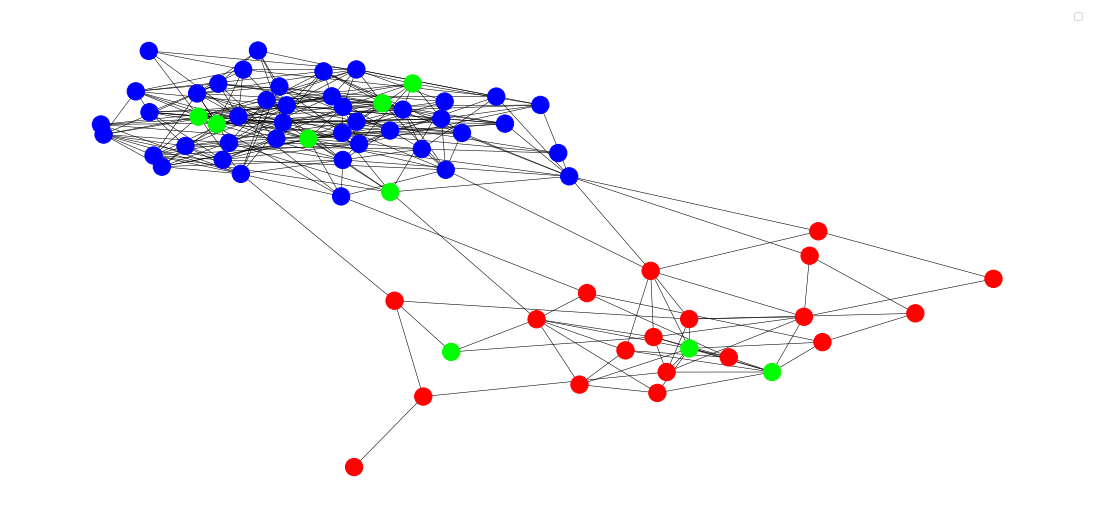

In [364]:
# Let's add the features and the labels of the citeseer dataset
import torch
import networkx as nx
from torch_geometric.utils import to_dense_adj
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import homophily
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Let's add the features and the labels of the citeseer dataset
from torch_geometric.datasets import Planetoid, WikipediaNetwork
from torch_geometric.utils import homophily
dataset = Planetoid(root='./data', name='citeseer')
#dataset = WikipediaNetwork(root='./data', name='squirrel')
data_citeseer = dataset[0]
print(data_citeseer)
print("Number of classes: ", dataset.num_classes)
# Let's choose 35 nodes from each class of citeseer
labels_of_class_0 = data_citeseer.y == 0
features_of_class_0 = data_citeseer.x[labels_of_class_0]
labels_of_class_1 = data_citeseer.y == 1
features_of_class_1 = data_citeseer.x[labels_of_class_1]
labels_of_class_2 = data_citeseer.y == 2
features_of_class_2 = data_citeseer.x[labels_of_class_2]

# Let's assing to data the features and the labels of the 35 nodes of each class
data.x = torch.cat((
                features_of_class_0[:30],
                features_of_class_2[0:1],
                features_of_class_2[30:33],
                features_of_class_2[1:2],
                features_of_class_2[2:6], 
                features_of_class_0[45:54],
                
                features_of_class_1[:3],
                features_of_class_2[7:8],
                features_of_class_1[6:11],
                features_of_class_2[9:11],
                features_of_class_1[12:23],
),dim=0)
                
data.y = torch.cat((
                        data_citeseer.y[labels_of_class_0][:30],  # 30
                        data_citeseer.y[labels_of_class_2][0:1],  # 1
                        data_citeseer.y[labels_of_class_0][30:33],# 
                        data_citeseer.y[labels_of_class_2][1:2],  # 1
                        data_citeseer.y[labels_of_class_2][2:6],  # 4
                        data_citeseer.y[labels_of_class_0][45:54],# 9
                                                                  # 
                        data_citeseer.y[labels_of_class_1][:3],
                        data_citeseer.y[labels_of_class_2][7:8],
                        data_citeseer.y[labels_of_class_1][6:11],
                        data_citeseer.y[labels_of_class_2][9:10],
                        data_citeseer.y[labels_of_class_2][7:8],
                        data_citeseer.y[labels_of_class_1][12:23],
),dim=0)

# Let's permutate the nodes
print("Number of nodes of class 0: ",len(data.y[data.y==0]))
print("Number of nodes of class 1: ",len(data.y[data.y==1]))
print("Number of nodes of class 2: ",len(data.y[data.y==2]))
# Let's create the train and test mask

train_mask, val_mask, test_mask = rand_train_test_idx(data.y,seed=1234)
print(data)
# PLot the graph
plt.figure(figsize=(15,7))
nx.draw(G,
        pos=pos,
        node_color= data.y,
        edge_color='black',
        width=0.55,
        style='solid',
        linewidths=1,
        cmap=plt.cm.brg,
        #node_size=100,
        with_labels=False,
        alpha=1,
        )
homofilia = homophily( data.edge_index, data.y, method='node')
#plt.title(f'Homophily: {homofilia:.3f}', fontsize=20)
plt.legend()
plt.show()

In [365]:
import torch
# Trace of a tensor [1,k,k]
def _rank3_trace(x):
    return torch.einsum('ijj->i', x)

# Diagonal version of a tensor [1,n] -> [1,n,n]
def _rank3_diag(x):
    eye = torch.eye(x.size(1)).type_as(x)
    out = eye * x.unsqueeze(2).expand(*x.size(), x.size(1)) 
    return out

def pump(adj, s): 
    adj = adj.unsqueeze(0) if adj.dim() == 2 else adj # adj torch.Size([20, N, N]) N=Mmax
    s = s.unsqueeze(0) if s.dim() == 2 else s # s torch.Size([20, N, k])
    k = s.size(-1)
    s = torch.tanh(s) # torch.Size([20, N, k]) One k for each N of each graph
    d_flat = torch.einsum('ijk->ij', adj) # torch.Size([20, N]) 
    d = _rank3_diag(d_flat) # d torch.Size([20, N, N]) 
    
    CT_num = _rank3_trace(torch.matmul(torch.matmul(s.transpose(1, 2),adj), s)) # Tr(S^T A S) 
    CT_den = _rank3_trace(torch.matmul(torch.matmul(s.transpose(1, 2), d), s))  # Tr(S^T D S) 
    adj = torch.cdist(s,s,p=2) # Distance matrix
    vol = _rank3_trace(d) # Vol(G)
    adj = (adj) / vol.unsqueeze(1).unsqueeze(1) # Distance matrix normalized
    # Mask with adjacency if proceeds 
    CT_loss = -(CT_num / CT_den) # Tr(S^T A S) / Tr(S^T D S)
    CT_loss = torch.mean(CT_loss)
    
    # Orthogonality regularization.
    ss = torch.matmul(s.transpose(1, 2), s)  
    i_s = torch.eye(k).type_as(ss) 
    ortho_loss = torch.norm(
        ss / torch.norm(ss, dim=(-1, -2), keepdim=True) -
        i_s )  
    ortho_loss = torch.mean(ortho_loss)
    del d
    del vol
    del d_flat
    return s, CT_loss, ortho_loss,adj 

In [366]:
from torch_geometric.nn import GCNConv,DenseGCNConv
from torch.nn import Linear
import torch.nn.functional as F

class ODwire(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels,num_centers,adj_dim, n_layers,out_channels,drop_out = 0.5):
        super(ODwire, self).__init__()
        torch.manual_seed(1234)
        self.MLP = Linear(adj_dim, num_centers)
        #GNN
        self.convs = torch.nn.ModuleList()
        for i in range(n_layers):
            self.convs.append(DenseGCNConv(in_channels, hidden_channels))
        #Extra conv
        self.conv_extra = DenseGCNConv(in_channels, hidden_channels)
        self.conv_extra2 = DenseGCNConv(hidden_channels, hidden_channels)
        #Aux
        self.drop_out = drop_out
        self.new_adj = None
        self.embeddings = None
        self.gnn_out = None
        # Parameters
        self.att = torch.nn.Parameter(torch.ones(n_layers + 1))
        self.sm = torch.nn.Softmax(dim=0)
        # Linear
        self.classify1 = Linear(hidden_channels*(n_layers + 1), out_channels)
    def forward(self, x, adj):
        mask_attentions = self.sm(self.att)
        extra_conv = self.conv_extra(x, adj.unsqueeze(0)).squeeze(0).relu() 
        extra_conv = F.dropout(extra_conv, p=self.drop_out, training=self.training)
        extra_conv = self.conv_extra2(extra_conv, adj.unsqueeze(0)).squeeze(0).relu() * mask_attentions[-1]
        s = self.MLP(adj)
        _, pump_loss, ortho_loss,distance_matrix= pump(adj, s)
        distance_matrix = distance_matrix.squeeze(0)
        new_adj = distance_matrix
        self.embeddings = s
        z_s = []
        previous_adj = torch.zeros_like(new_adj)
        for i, conv in enumerate(self.convs):
            adj = torch.zeros_like(new_adj)
            top_min = torch.topk(new_adj, i, dim=1, largest=False, sorted=True)
            adj.scatter_(1, top_min.indices, 1)
            adj = torch.mul(adj, torch.exp(-new_adj))
            adj = adj - previous_adj
            z = conv(x, adj.unsqueeze(0)).squeeze(0).relu() * mask_attentions[i]
            z_s.append(z)
            previous_adj = adj
        del previous_adj
        del adj
        final_z = torch.cat(z_s, dim=1)
        final_z = torch.cat([final_z, extra_conv], dim=1)
        final_z = F.dropout(final_z, p=self.drop_out, training=self.training)
        z = self.classify1(final_z).log_softmax(dim=-1)    
        self.gnn_out = z
        return z, (pump_loss + ortho_loss)

In [367]:
def train_adj(adj,data,model,optimizer):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      _,loss,new_adj = model(data.x, adj)  # Perform a single forward pass.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,new_adj

'''
      train function:
            * Inputs:
                  - adj: torch tensor of adjacency matrix
                  - data: torch tensor of data
                  - model: torch model
                  - train_mask: torch tensor of boolean values, True if data is in training set
                  - optimizer: torch optimizer
                  - criterion: torch loss function
            * Outputs:
                  - loss: torch tensor of loss
                  - train_acc: float of training accuracy
            * Description:
                  - performs the training step of the model, taking into account the pump loss 
                  and the cross entropy loss, only tacking into account the training nodes.
'''
def train(adj,data,model,train_mask,optimizer,criterion):
      model.train() # Set model to training mode.
      optimizer.zero_grad()  # Clear gradients.
      out,loss_norm = model(data.x, adj)  # Perform a single forward pass.
      #Get the accuracy of the model
      pred = out.argmax(dim=1).squeeze(0)  # Use the class with highest probability.
      train_correct = pred[train_mask] == data.y[train_mask]  # Check against ground-truth labels.
      train_acc = int(train_correct.sum()) / int(train_mask.sum())  # Derive ratio of correct predictions.
      loss =  loss_norm + criterion(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss,train_acc
  
'''
      val function:
            * Inputs:
                  - adj: torch tensor of adjacency matrix
                  - data: torch tensor of data
                  - model: torch model
                  - val_mask: torch tensor of boolean values, True if data is in validation set 
            * Outputs:
                  - val_acc: float of validation accuracy
            * Description:
                  - performs the validation step of the model, only tacking into account the validation nodes.
'''  
def val(adj,data,model,val_mask):
      model.eval() # Set model to evaluation mode.
      out,_ = model(data.x, adj) # Perform a single forward pass.
      pred = out.argmax(dim=1).squeeze(0)  # Use the class with highest probability.
      test_correct = pred[val_mask] == data.y[val_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(val_mask.sum())  # Derive ratio of correct predictions.
      return test_acc
'''
      test function:
            * Inputs:
                  - adj: torch tensor of adjacency matrix
                  - data: torch tensor of data
                  - model: torch model
                  - test_mask: torch tensor of boolean values, True if data is in validation set 
            * Outputs:
                  - test_acc: float of validation accuracy
            * Description:
                  - performs the validation step of the model, only tacking into account the testing nodes.
'''    
def test(adj,data,model,test_mask):
      model.eval() # Set model to evaluation mode.
      out,_ = model(data.x, adj) # Perform a single forward pass.
      pred = out.argmax(dim=1).squeeze(0)  # Use the class with highest probability.
      test_correct = pred[test_mask] == data.y[test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


In [368]:

import matplotlib.pyplot as plt
model = ODwire(in_channels=dataset.num_features,
                                hidden_channels=32,
                                num_centers=3,
                                adj_dim = adj.shape[0],
                                n_layers= 2,
                                out_channels=dataset.num_classes).to(device)
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
test_acc = 0
adjs_in_real_time_supervised = []
embeddings_supervised = []
gnn_out_supervised = []
best_model = None
for epoch in range(300):
    loss,acc_train = train(adj,data,model,train_mask,optimizer,criterion)
    gnn_out_supervised.append(model.gnn_out)
    adjs_in_real_time_supervised.append(model.new_adj)
    embeddings_supervised.append(model.embeddings)
    acc_val = val(adj,data,model,val_mask)
    acc_test = test(adj,data,model,test_mask)
    if acc_test > test_acc:
        test_acc = acc_test
        # We save the model
        best_model = torch.save(model.state_dict(), 'best_model.pth')
        z = model.gnn_out
        print("The best iterarion is: ",epoch)
    # Now let's assign for every node of z the corresponding cluster using kmeans
    from sklearn.cluster import KMeans
    from sklearn.manifold import TSNE
    #kmeans = KMeans(n_clusters=5, random_state=0).fit(z.squeeze(0).detach().cpu().numpy())
    # Let's plot the kmeans over the embedding
    #tsne = TSNE(n_components=2, random_state=123)#,init='pca',learning_rate=200.0)
    #tsne_obj = tsne.fit_transform(z.squeeze(0).detach().cpu().numpy())
    #plt.figure(figsize=(20,10))
    #plt.title('Epoch: {}, Loss: {:.4f}, Train Acc: {:.4f}, Val Acc: {:.4f}, Test Acc: {:.4f}'.format(epoch,loss,acc_train,acc_val,acc_test),fontsize=20)
    #sns.scatterplot(x=tsne_obj[:,0], y=tsne_obj[:,1],s=100,hue=data.y,palette='viridis')
    #plt.show()

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {acc_train:.4f}, Val Acc: {acc_val:.4f}, Test Acc: {acc_test:.4f}')
print('===========================================================================================================')
print('Test Accuracy: ',test_acc)
print('===========================================================================================================')

The best iterarion is:  0
Epoch: 000, Loss: 2.5682, Train Acc: 0.0000, Val Acc: 0.1765, Test Acc: 0.5000
The best iterarion is:  1
Epoch: 001, Loss: 2.2241, Train Acc: 0.6000, Val Acc: 0.8824, Test Acc: 0.7778
Epoch: 002, Loss: 1.9729, Train Acc: 0.8286, Val Acc: 0.8824, Test Acc: 0.6667
Epoch: 003, Loss: 1.6579, Train Acc: 0.8571, Val Acc: 0.8824, Test Acc: 0.5000
Epoch: 004, Loss: 1.3944, Train Acc: 0.8571, Val Acc: 0.8824, Test Acc: 0.5000
Epoch: 005, Loss: 1.0926, Train Acc: 0.8000, Val Acc: 0.8824, Test Acc: 0.5000
Epoch: 006, Loss: 0.7967, Train Acc: 0.9143, Val Acc: 0.8824, Test Acc: 0.5556
Epoch: 007, Loss: 0.6653, Train Acc: 0.8286, Val Acc: 0.8824, Test Acc: 0.6667
Epoch: 008, Loss: 0.5853, Train Acc: 0.8571, Val Acc: 0.8824, Test Acc: 0.7222
Epoch: 009, Loss: 0.4654, Train Acc: 0.8571, Val Acc: 0.9412, Test Acc: 0.7222
The best iterarion is:  10
Epoch: 010, Loss: 0.3469, Train Acc: 0.9429, Val Acc: 0.9412, Test Acc: 0.8333
Epoch: 011, Loss: 0.3078, Train Acc: 0.9429, Val Acc

Test Accuracy:  0.9444444444444444
torch.Size([70, 3])
torch.Size([70, 70])
torch.Size([70, 70])
tensor([0.7313, 0.7923, 0.8341])
Autovalores tensor([0.7313, 0.7923, 0.8341])
torch.Size([70, 70])


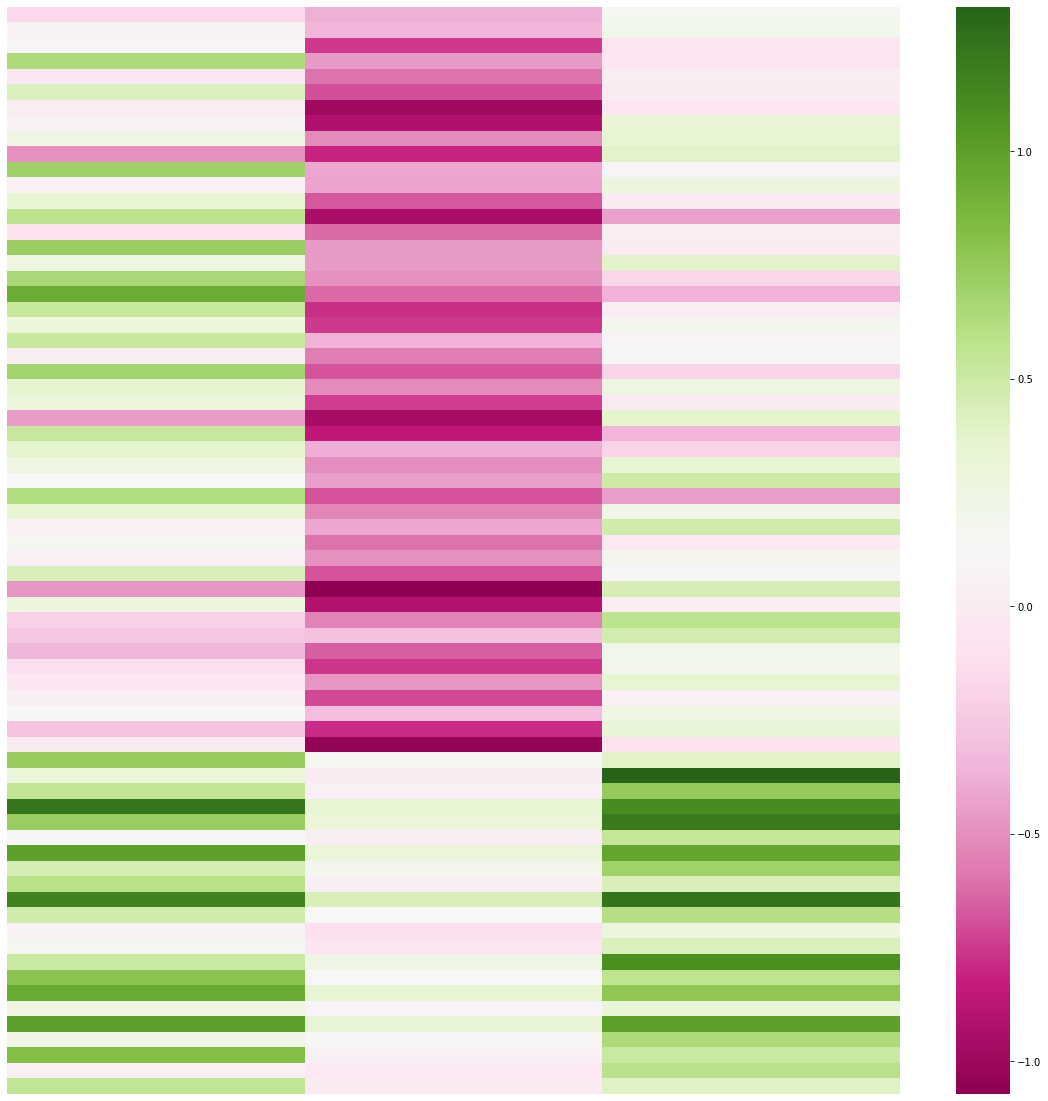

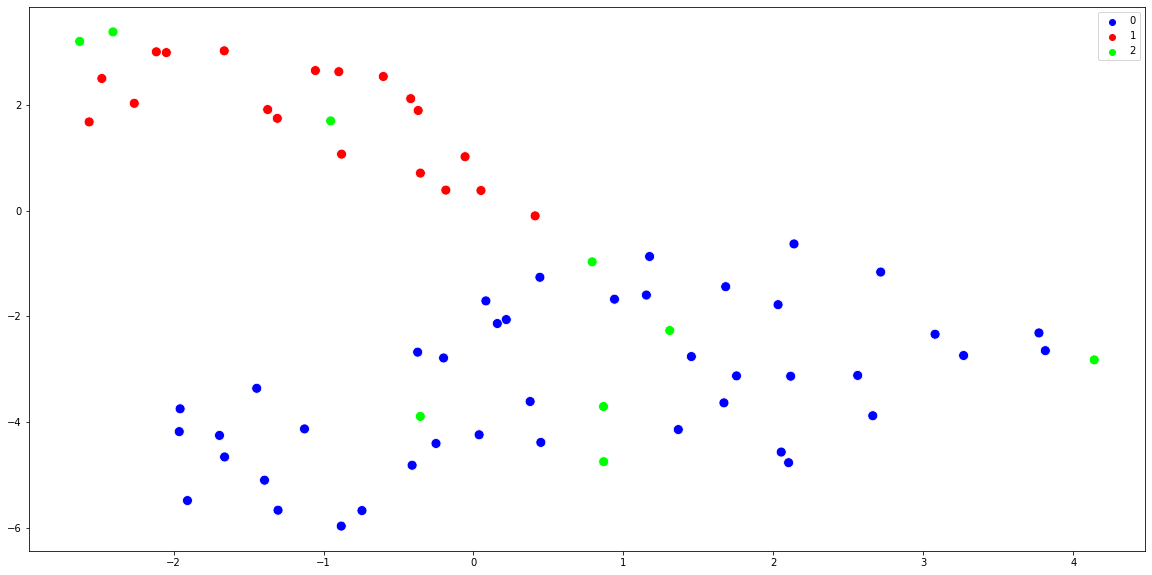

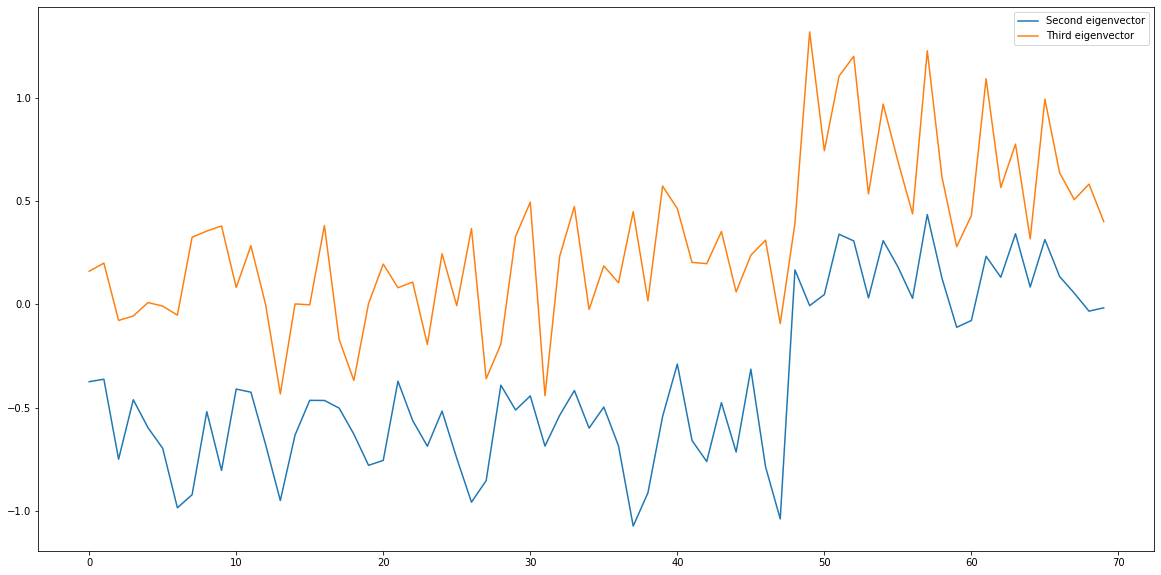

In [369]:
# Leemos el mejor modelo
model.load_state_dict(torch.load('best_model.pth'))
best_model = model
from torchviz import make_dot
embeddings = best_model.gnn_out
make_dot(best_model.gnn_out, params=dict(best_model.named_parameters())).view()
# Le pasamos el mejor modelo a la función de test
acc_test = test(adj,data,best_model,test_mask)
print('===========================================================================================================')
print('Test Accuracy: ',acc_test)
print('===========================================================================================================')
import seaborn as sns
embeddings = best_model.embeddings.squeeze(0).detach().cpu()
print(embeddings.shape)
# Get the degree matrix of adj  
d = torch.sum(adj.squeeze(0), dim=1)
# put it in the diagonal of a matrix
D = torch.diag(d)
print(D.shape)
# Compute the Laplacian
L = D - adj.squeeze(0)
print(L.shape)
# Compute the eigen values
#eign = embeddings.T @ L @ embeddings
CT_num = torch.sum(torch.matmul(torch.matmul(embeddings.transpose(0, 1),adj.squeeze(0)), embeddings), dim=1) # [20, k, N]*[20, N, N]->[20, k, N]*[20, N, k] -> [20] one sum over each graph
CT_den = torch.sum(torch.matmul(torch.matmul(embeddings.transpose(0, 1), D), embeddings), dim=1) # [20, k, N]*[20, N, N]->[20, k, N]*[20, N, k] -> [20] one sum over each graph
print(CT_num/CT_den)    
diagonal_eign = CT_num/CT_den
# Now sort the eigen values
_, indices = torch.sort(diagonal_eign, descending=False)
# Sort the embeddings
embeddings = embeddings[:, indices]
# And the eigen values
diagonal_eign = torch.sort(diagonal_eign, descending=False)[0]
print("Autovalores",diagonal_eign)
print(L.shape)
plt.figure(figsize=(20,20))
sns.heatmap(embeddings.numpy(), cmap='PiYG', xticklabels=False, yticklabels=False)
plt.show()
z = best_model.embeddings.squeeze(0).detach().cpu()
# Now let's assign for every node of z the corresponding cluster using kmeans
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
#kmeans = KMeans(n_clusters=5, random_state=0).fit(z.squeeze(0).detach().cpu().numpy())
# Let's plot the kmeans over the embedding
tsne = TSNE(n_components=2, random_state=42,init='pca',learning_rate=200.0)
tsne_obj = tsne.fit_transform(z.squeeze(0).detach().cpu().numpy())
plt.figure(figsize=(20,10))
sns.scatterplot(x=tsne_obj[:,0], y=tsne_obj[:,1],s=100,hue=data.y[:],palette='brg')
plt.show()
# Let's get the second and third eigenvector
second_eigenvector = embeddings[:,1]
third_eigenvector = embeddings[:,2]
# Now let's asume they are functions and let's plot them
plt.figure(figsize=(20,10))
plt.plot(second_eigenvector.detach().cpu().numpy(),label='Second eigenvector')
plt.plot(third_eigenvector.detach().cpu().numpy(),label='Third eigenvector')
plt.legend()
plt.show()

(70, 6)


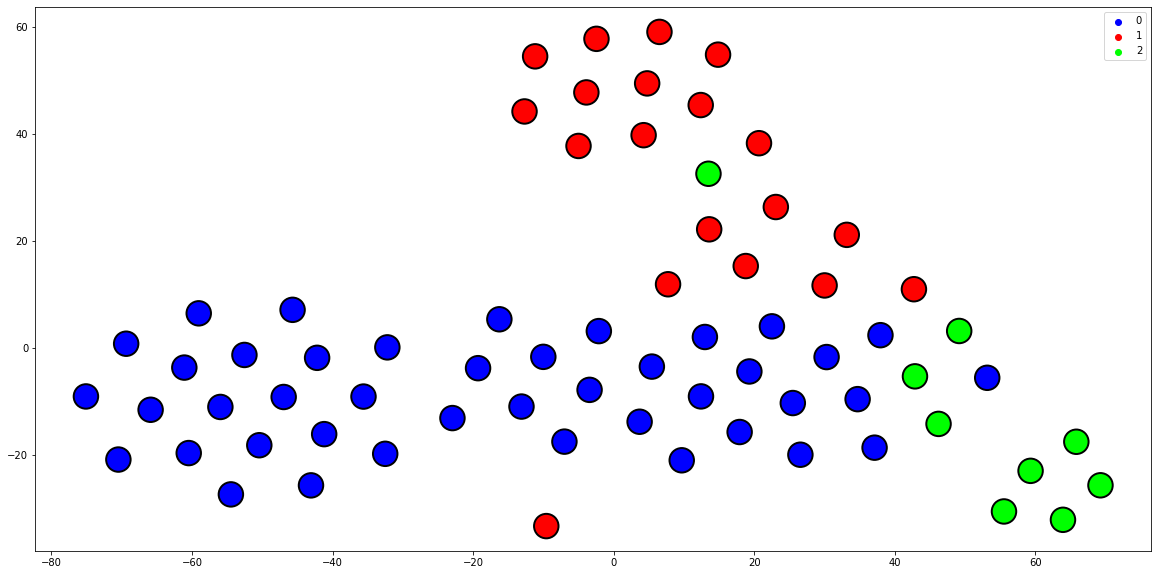

In [308]:
gnn_out_supervised = best_model.gnn_out.squeeze(0).detach().cpu().numpy()
print(gnn_out_supervised.shape)
plt.figure(figsize=(20,10))
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=101)
tsne_obj = tsne.fit_transform(gnn_out_supervised)
# Intercambiamos los siguientes nodos:
# 58 -> 32
#tsne_obj[58],tsne_obj[32] = tsne_obj[32],tsne_obj[58]
# 32 -> 52
#tsne_obj[32],tsne_obj[52] = tsne_obj[52],tsne_obj[32]
# 13 -> 35
#tsne_obj[13],tsne_obj[35] = tsne_obj[35],tsne_obj[13]
# 52 -> 31
#tsne_obj[52],tsne_obj[31] = tsne_obj[31],tsne_obj[52]
# Con puntos más grandes y con bordes más oscuros
sns.scatterplot(x=tsne_obj[:,0], y=tsne_obj[:,1],s=600,hue=data.y,palette='brg',edgecolor='black',alpha=1)
plt.show()

In [309]:
class ODwire_unsupervised(torch.nn.Module):
    def __init__(self, in_channels, adj_dim, hidden_channels, num_centers):
        super(ODwire_unsupervised, self).__init__()
        torch.manual_seed(1234)
        # CT-Layer
        self.MLP_adj = Linear(adj_dim, num_centers)
        self.embedding = None
    def forward(self, x, adj):
        s = self.MLP_adj(adj)
        self.embedding = s
        _, CT_loss, ortho_loss, new_adj= pump(adj, s)
        return s, CT_loss + ortho_loss, new_adj

In [310]:
adj = to_dense_adj(data.edge_index)[0].to(device)
print(adj.shape[0])
unsupervised_model = ODwire_unsupervised(in_channels=dataset.num_features,
                                            adj_dim=adj.shape[0],
                                            hidden_channels=0,                            
                                            num_centers=3).to(device)
unsupervised_model.train()   
optimizer = torch.optim.Adam(unsupervised_model.parameters(), lr=0.01, weight_decay=5e-4)
losses = []
adjs_in_real_time = []
embeddings_non_supervised = []
for epoch in range(300):
    loss , new_adj = train_adj(adj,data,unsupervised_model,optimizer)
    embeddings_non_supervised.append(unsupervised_model.embedding.detach().cpu())
    losses.append(loss.item())
    new_adj = new_adj.detach().squeeze(0).to('cpu')
    adjs_in_real_time.append(new_adj)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
print('===========================================================================================================')
print('Final loss: ',loss.item())
print('===========================================================================================================')
adj_re = new_adj.detach().squeeze(0)#.numpy()

70
Epoch: 000, Loss: 0.7446
Epoch: 001, Loss: 0.5143
Epoch: 002, Loss: 0.4541
Epoch: 003, Loss: 0.4071
Epoch: 004, Loss: 0.3624
Epoch: 005, Loss: 0.3154
Epoch: 006, Loss: 0.2664
Epoch: 007, Loss: 0.2228
Epoch: 008, Loss: 0.1949
Epoch: 009, Loss: 0.1819
Epoch: 010, Loss: 0.1708
Epoch: 011, Loss: 0.1529
Epoch: 012, Loss: 0.1297
Epoch: 013, Loss: 0.1075
Epoch: 014, Loss: 0.0916
Epoch: 015, Loss: 0.0814
Epoch: 016, Loss: 0.0732
Epoch: 017, Loss: 0.0636
Epoch: 018, Loss: 0.0516
Epoch: 019, Loss: 0.0383
Epoch: 020, Loss: 0.0258
Epoch: 021, Loss: 0.0157
Epoch: 022, Loss: 0.0083
Epoch: 023, Loss: 0.0027
Epoch: 024, Loss: -0.0023
Epoch: 025, Loss: -0.0070
Epoch: 026, Loss: -0.0108
Epoch: 027, Loss: -0.0133
Epoch: 028, Loss: -0.0143
Epoch: 029, Loss: -0.0148
Epoch: 030, Loss: -0.0157
Epoch: 031, Loss: -0.0175
Epoch: 032, Loss: -0.0201
Epoch: 033, Loss: -0.0229
Epoch: 034, Loss: -0.0254
Epoch: 035, Loss: -0.0273
Epoch: 036, Loss: -0.0288
Epoch: 037, Loss: -0.0303
Epoch: 038, Loss: -0.0321
Epoch: 

torch.Size([70, 3])
torch.Size([70, 70])
torch.Size([70, 70])
tensor([0.8259, 0.9455, 0.9645])
Autovalores tensor([0.8259, 0.9455, 0.9645])
torch.Size([70, 70])


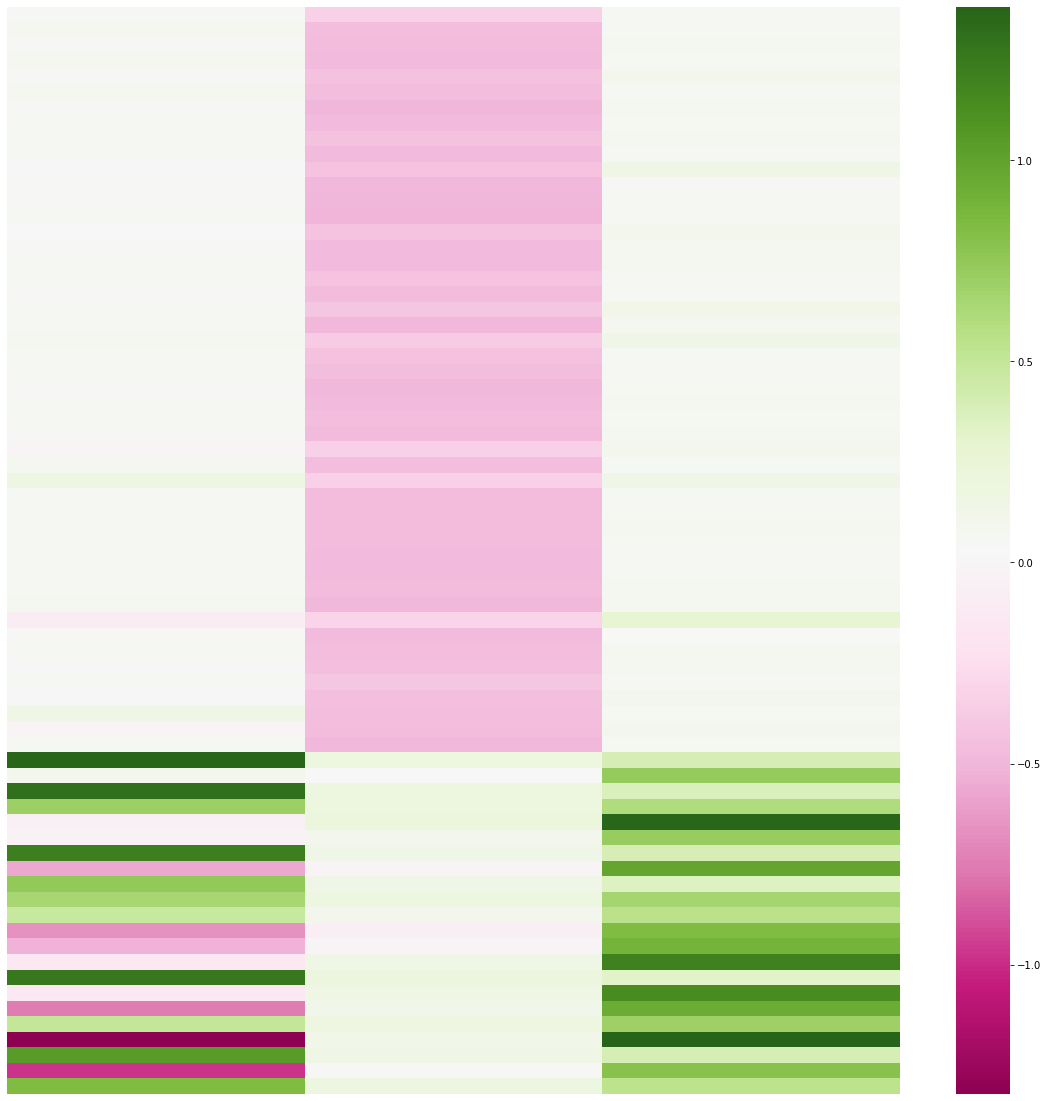

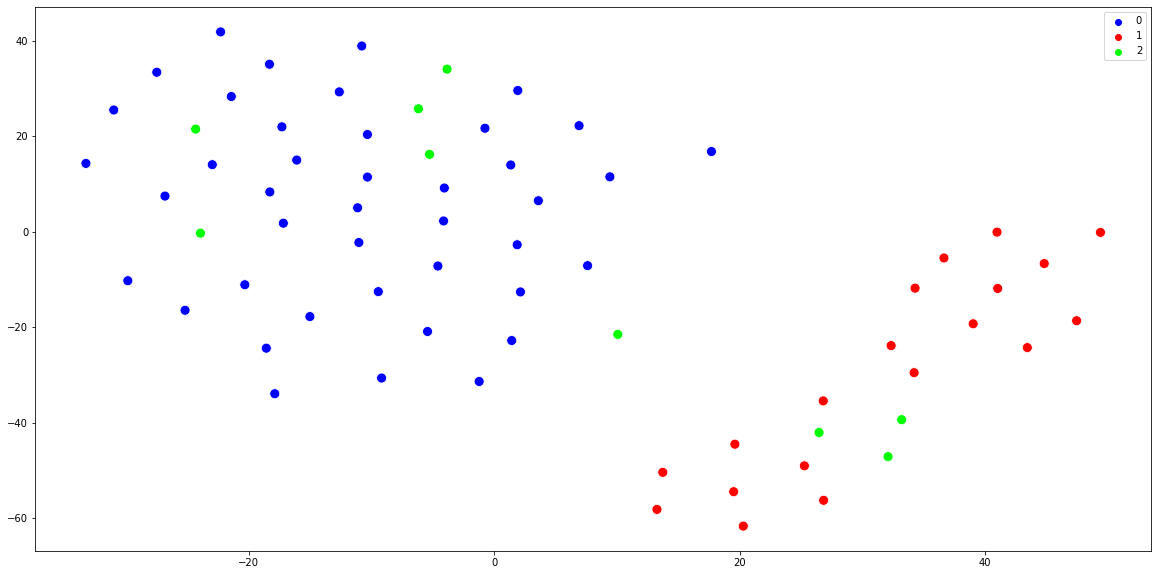

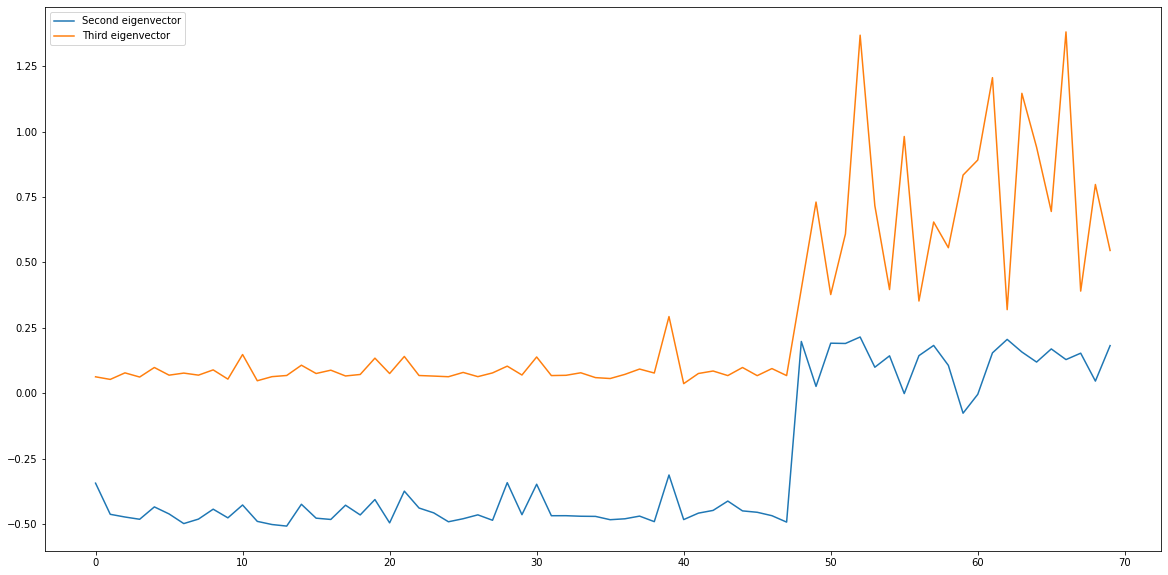

In [311]:
embeddings = unsupervised_model.embedding.squeeze(0).detach().cpu()
print(embeddings.shape)
# Get the degree matrix of adj  
d = torch.sum(adj.squeeze(0), dim=1)
# put it in the diagonal of a matrix
D = torch.diag(d)
print(D.shape)
# Compute the Laplacian
L = D - adj.squeeze(0)
print(L.shape)
# Compute the eigen values
#eign = embeddings.T @ L @ embeddings
CT_num = torch.sum(torch.matmul(torch.matmul(embeddings.transpose(0, 1),adj.squeeze(0)), embeddings), dim=1) # [20, k, N]*[20, N, N]->[20, k, N]*[20, N, k] -> [20] one sum over each graph
CT_den = torch.sum(torch.matmul(torch.matmul(embeddings.transpose(0, 1), D), embeddings), dim=1) # [20, k, N]*[20, N, N]->[20, k, N]*[20, N, k] -> [20] one sum over each graph
print(CT_num/CT_den)    
diagonal_eign = CT_num/CT_den
# Now sort the eigen values
_, indices = torch.sort(diagonal_eign, descending=False)
# Sort the embeddings
embeddings = embeddings[:, indices]
# And the eigen values
diagonal_eign = torch.sort(diagonal_eign, descending=False)[0]
print("Autovalores",diagonal_eign)
print(L.shape)
plt.figure(figsize=(20,20))
sns.heatmap(embeddings.numpy(), cmap='PiYG', xticklabels=False, yticklabels=False)
plt.show()
z = unsupervised_model.embedding.squeeze(0).detach().cpu()
# Now let's assign for every node of z the corresponding cluster using kmeans
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
#kmeans = KMeans(n_clusters=5, random_state=0).fit(z.squeeze(0).detach().cpu().numpy())
# Let's plot the kmeans over the embedding
tsne = TSNE(n_components=2, random_state=42,init='pca',learning_rate=200.0)
tsne_obj = tsne.fit_transform(z.squeeze(0).detach().cpu().numpy())
plt.figure(figsize=(20,10))
sns.scatterplot(x=tsne_obj[:,0], y=tsne_obj[:,1],s=100,hue=data.y[:],palette='brg')
plt.show()
# Let's get the second and third eigenvector
second_eigenvector = embeddings[:,1]
third_eigenvector = embeddings[:,2]
# Now let's asume they are functions and let's plot them
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,len(second_eigenvector.detach().cpu().numpy())),second_eigenvector.detach().cpu().numpy(),label='Second eigenvector')
plt.plot(np.arange(0,len(third_eigenvector.detach().cpu().numpy())),third_eigenvector.detach().cpu().numpy(),label='Third eigenvector')
plt.legend()
plt.show()

[2.15105711e-16 5.25618455e-02 2.94340375e-01 3.54454182e-01
 4.86521420e-01 5.05708049e-01 5.44608458e-01 5.50950673e-01
 5.67997689e-01 6.01850809e-01 6.13694401e-01 6.29386338e-01
 6.37679177e-01 6.54350649e-01 6.76445482e-01 7.02469431e-01
 7.20556648e-01 7.32587292e-01 7.45869786e-01 7.77261960e-01
 8.01871997e-01 8.07792417e-01 8.22932427e-01 8.40741923e-01
 8.42784310e-01 8.66120952e-01 8.92840016e-01 9.23420636e-01
 9.33194860e-01 9.39876517e-01 9.50065020e-01 9.64131561e-01
 9.71356596e-01 9.87826430e-01 9.92882813e-01 1.00889282e+00
 1.05390184e+00 1.07008523e+00 1.08362846e+00 1.08992696e+00
 1.09834389e+00 1.12658943e+00 1.14071407e+00 1.14848871e+00
 1.15201577e+00 1.18222377e+00 1.18689178e+00 1.21247529e+00
 1.22535896e+00 1.23375948e+00 1.24738069e+00 1.26324142e+00
 1.28251922e+00 1.29729170e+00 1.31597578e+00 1.33773404e+00
 1.34817079e+00 1.37115693e+00 1.39953740e+00 1.40432311e+00
 1.42481360e+00 1.43822482e+00 1.44528793e+00 1.47395566e+00
 1.49351726e+00 1.519857

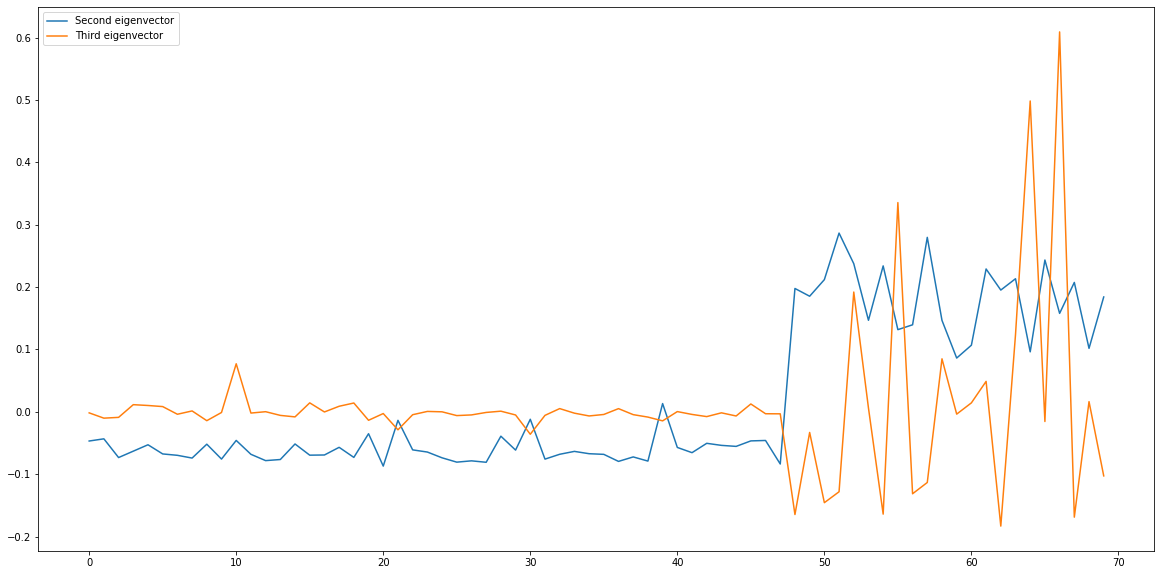

In [313]:
adj = to_dense_adj(data.edge_index)[0].to(device)
# Let's get the eigenvectors of the Laplacian
g_mala = nx.from_numpy_matrix(adj.squeeze(0).detach().cpu().numpy())
L = nx.normalized_laplacian_matrix(g_mala).todense()
eigenvalues, eigenvectors = np.linalg.eig(L)
eigenvalues = np.sort(eigenvalues)
eigenvectors = eigenvectors[:, eigenvalues.argsort()]
eigenvalues = eigenvalues[eigenvalues.argsort()]
print(eigenvalues)
print(eigenvectors)
# plot the second and third eigenvector
plt.figure(figsize=(20,10))
plt.plot(np.arange(0,len(eigenvectors[:,1])),eigenvectors[:,1],label='Second eigenvector')
plt.plot(np.arange(0,len(eigenvectors[:,2])),eigenvectors[:,2],label='Third eigenvector')
plt.legend()
plt.show()